In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
# from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
for dirname, _, filenames in os.walk('C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (19).jpg
C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (20).jpg
C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (21).jpg
C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (22).jpg
C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (23).jpg
C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (24).jpg
C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test\MildDemented\26 (25).jpg
C:/Use

In [4]:
images = []
labels = []
for subfolder in tqdm(os.listdir('C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/')):
    subfolder_path = os.path.join('C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
            
alz_df = pd.DataFrame({'image': images, 'label': labels})
alz_df

100%|██████████| 2/2 [00:00<00:00, 57.22it/s]


image             label
0     C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....      MildDemented
1     C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....      MildDemented
2     C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....      MildDemented
3     C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....      MildDemented
4     C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....      MildDemented
...                                                 ...               ...
6395  C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....  VeryMildDemented
6396  C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....  VeryMildDemented
6397  C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....  VeryMildDemented
6398  C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....  VeryMildDemented
6399  C:/Users/tessa/OneDrive/Documents/1. MS BMI/4....  VeryMildDemented

[6400 rows x 2 columns]

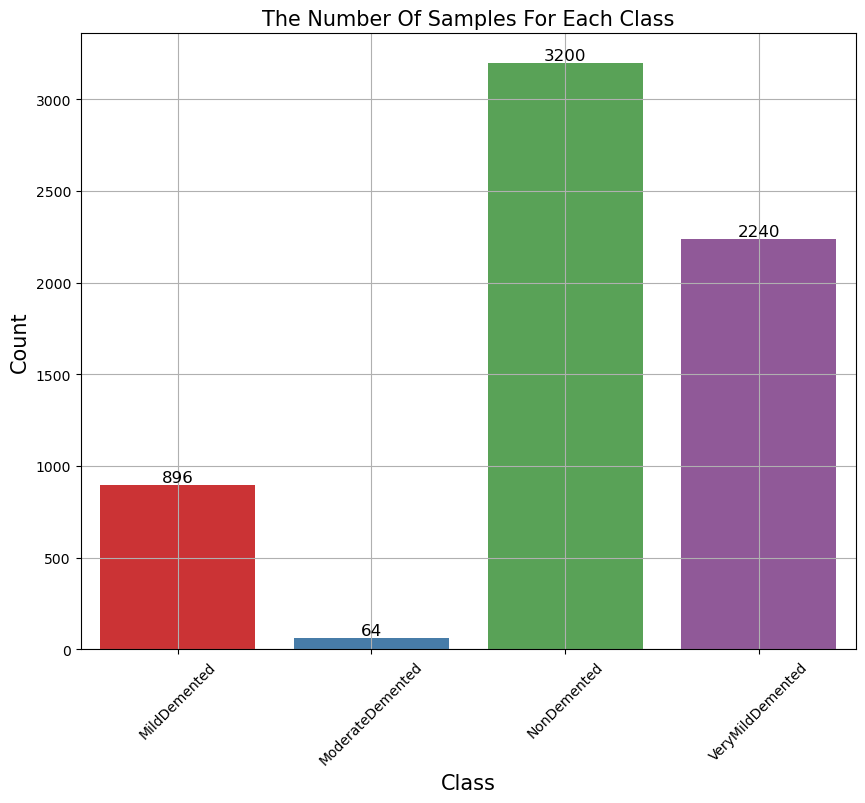

In [5]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x=alz_df.label,palette='Set1')
ax.bar_label(ax.containers[0], fontsize=12)
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('The Number Of Samples For Each Class',fontsize=15)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

The MRI image dataset is imbalanced. Oversampling 

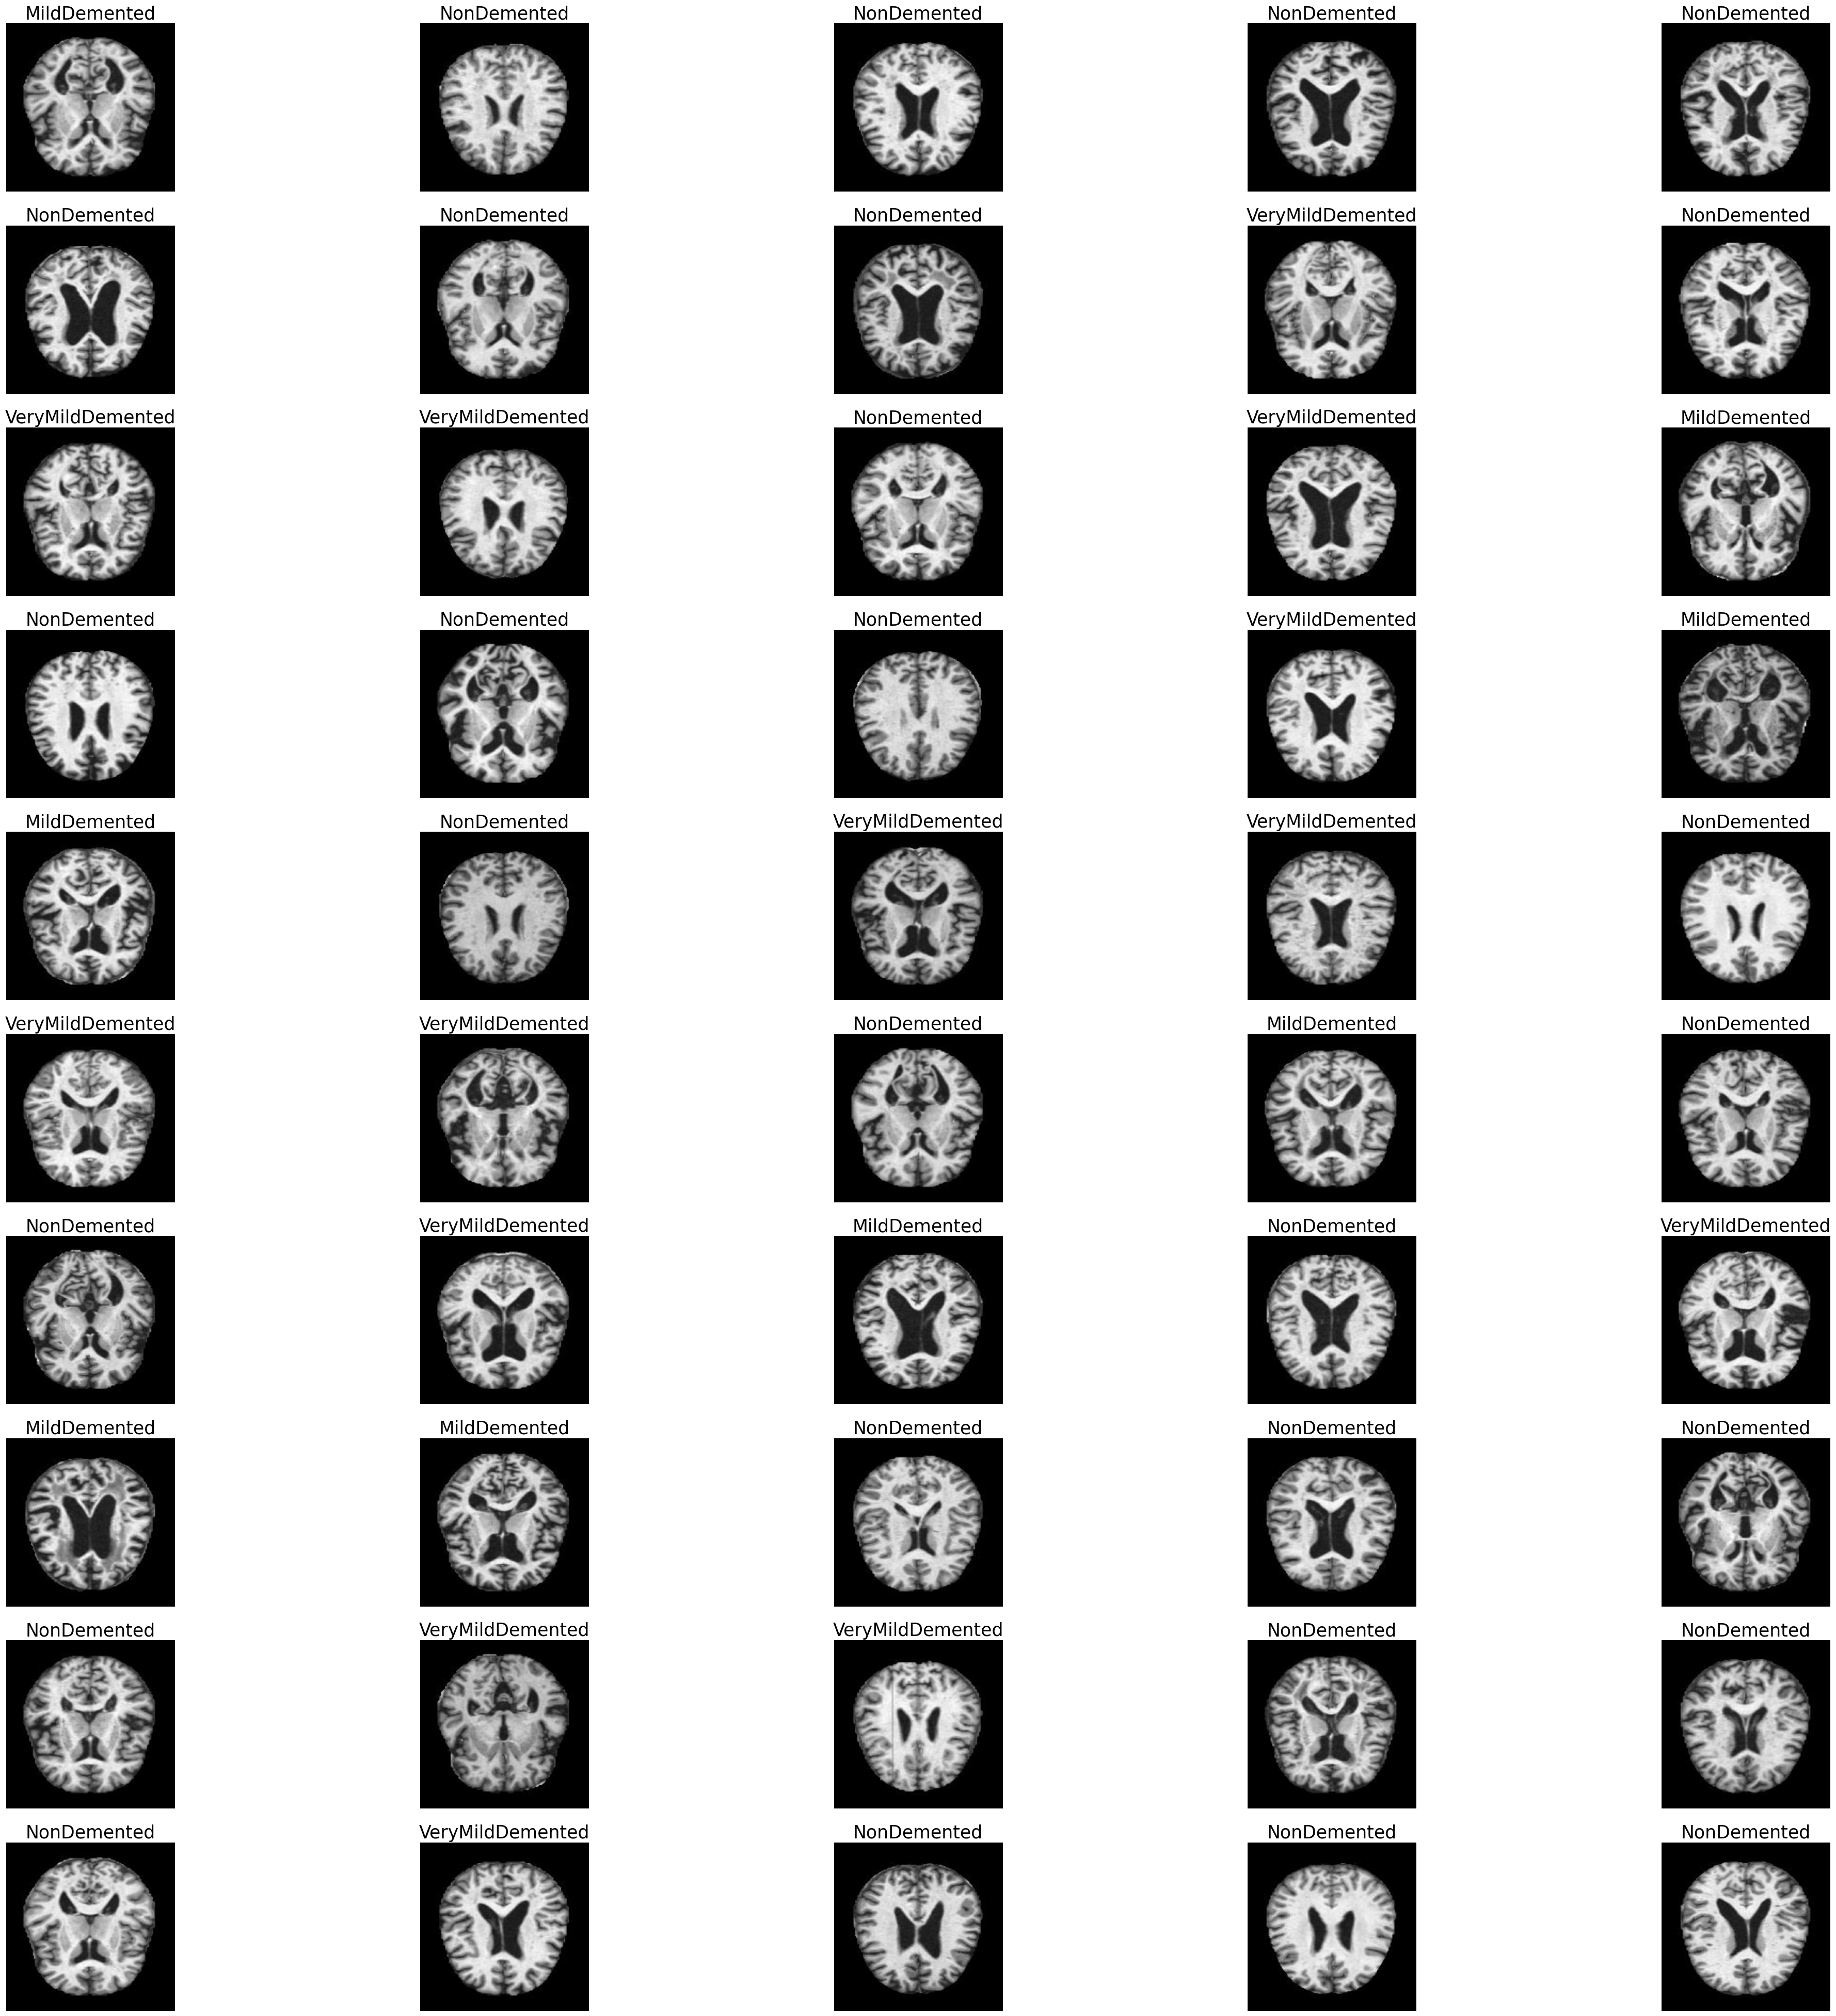

In [6]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(alz_df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(alz_df.image[i])
    img=cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(alz_df.label[i],fontsize=25)

# Data Augmentation

#### Preprocessing to use GAN to oversample.

In [86]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

Size=(28,28)

work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(alz_df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

# Define batch size
batch_size = 64

# Create DataLoader objects
dl_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(train_labels, batch_size=batch_size, shuffle=False)

print(len(dl_train))
print(len(dl_test))

Found 6400 validated image filenames belonging to 4 classes.
100
100


#### Back up oversample using SMOTE.

In [147]:
from imblearn.over_sampling import SMOTE

class_num = pd.unique(alz_df['label'])
class_num

sm = SMOTE(random_state=42)
train_data_sm, train_labels_sm = sm.fit_resample(train_data.reshape(-1, 28 * 28 * 3), train_labels)
train_data_sm = train_data_sm.reshape(-1, 28,28, 3)
print(train_data_sm.shape, train_labels_sm.shape)

(12800, 28, 28, 3) (12800, 4)


In [154]:
X_train, X_test, y_train, y_test = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)

C:\Users\tessa\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


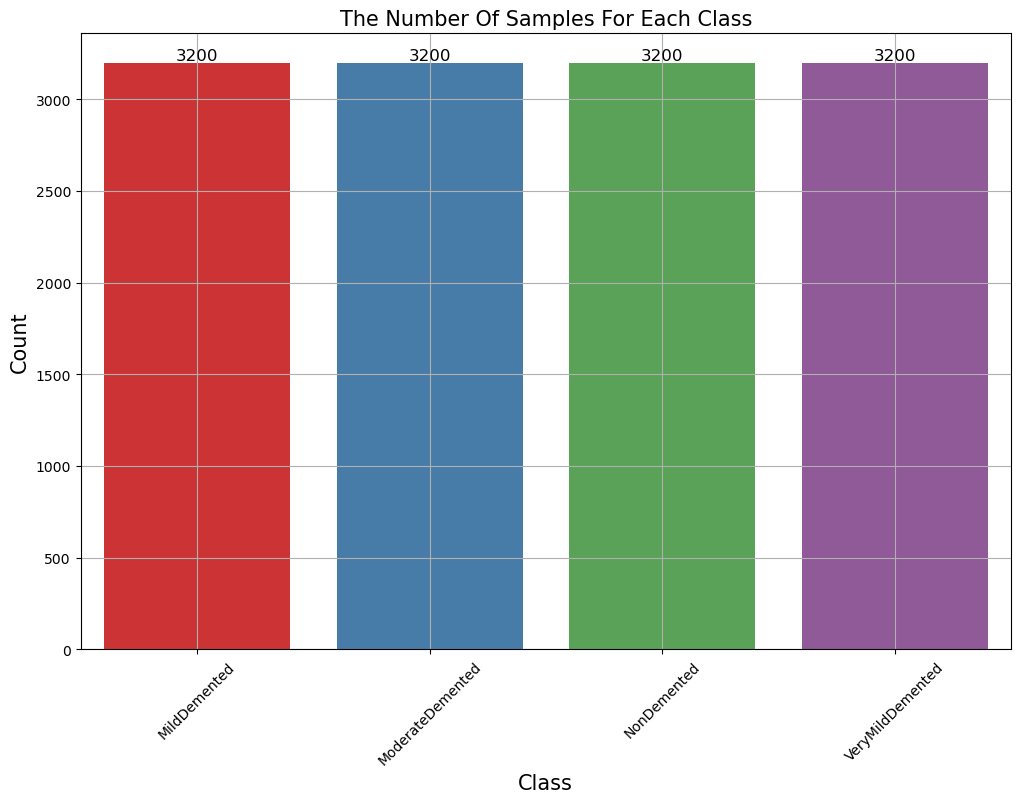

In [148]:
labels=[class_num[i] for i in np.argmax(train_labels_sm,axis=1) ]
plt.figure(figsize=(12,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.bar_label(ax.containers[0], fontsize=12)
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('The Number Of Samples For Each Class',fontsize=15)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# GAN for oversampling

In [94]:
batch_size = 64
codings_size = 100


g = nn.Sequential(
        nn.ConvTranspose2d(codings_size, 256, 7, 1, 0, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
        nn.Tanh()
)

# g = nn.Sequential(
#     nn.ConvTranspose2d(codings_size, 128, 2, 1, 0, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 64, 2, 2, 1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(),

#     nn.ConvTranspose2d(64, 32, 2, 2, 1, bias=False),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),

#     nn.ConvTranspose2d(32, 1, 2, 2, 1, bias=False),
#     nn.Tanh()
# )

display(summary(g, input_size=(batch_size, codings_size, 1, 1), device="cpu"))

d = nn.Sequential(
    nn.Conv2d(1, 32, 2, 2, 1, bias=False),
    nn.LeakyReLU(0.2),

    nn.Conv2d(32, 64, 2, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),

    nn.Conv2d(64, 128, 2, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),

    nn.Conv2d(128, 1, 2, 1, 0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

display(summary(d, input_size=(batch_size, 1, 28, 28), device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1, 56, 56]           --
├─ConvTranspose2d: 1-1                   [64, 256, 7, 7]           1,254,400
├─BatchNorm2d: 1-2                       [64, 256, 7, 7]           512
├─ReLU: 1-3                              [64, 256, 7, 7]           --
├─ConvTranspose2d: 1-4                   [64, 128, 14, 14]         524,288
├─BatchNorm2d: 1-5                       [64, 128, 14, 14]         256
├─ReLU: 1-6                              [64, 128, 14, 14]         --
├─ConvTranspose2d: 1-7                   [64, 64, 28, 28]          131,072
├─BatchNorm2d: 1-8                       [64, 64, 28, 28]          128
├─ReLU: 1-9                              [64, 64, 28, 28]          --
├─ConvTranspose2d: 1-10                  [64, 1, 56, 56]           1,024
├─Tanh: 1-11                             [64, 1, 56, 56]           --
Total params: 1,911,680
Trainable params: 1,911,680
Non-traina

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 16]                  --
├─Conv2d: 1-1                            [64, 32, 15, 15]          128
├─LeakyReLU: 1-2                         [64, 32, 15, 15]          --
├─Conv2d: 1-3                            [64, 64, 8, 8]            8,192
├─BatchNorm2d: 1-4                       [64, 64, 8, 8]            128
├─LeakyReLU: 1-5                         [64, 64, 8, 8]            --
├─Conv2d: 1-6                            [64, 128, 5, 5]           32,768
├─BatchNorm2d: 1-7                       [64, 128, 5, 5]           256
├─LeakyReLU: 1-8                         [64, 128, 5, 5]           --
├─Conv2d: 1-9                            [64, 1, 4, 4]             512
├─Flatten: 1-10                          [64, 16]                  --
├─Sigmoid: 1-11                          [64, 16]                  --
Total params: 41,984
Trainable params: 41,984
Non-trainable params: 0
Tota

In [95]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(g.parameters())
d_optimizer = torch.optim.Adam(d.parameters())

In [99]:
# # Training the generator
# def g_training_step(d, g, optimizer, x_batch):
#     batch_size = x_batch.size(0)
    
#     z = torch.randn(batch_size, codings_size, 1, 1)

#     pred_fake = d(g(z))
#     loss = loss_fn(pred_fake, torch.ones(batch_size, 1)) # Trying to fool the discriminator
#                                                          # by passing the fake data as real.

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
        
#     return loss.item()

def g_training_step(d, g, optimizer, x_batch):
    optimizer.zero_grad()
    z = torch.randn(batch_size, codings_size, 1, 1)
    pred_fake = d(g(z))
    target = torch.ones_like(pred_fake)  # Target tensor with ones (indicating real images)
    loss_fn = nn.BCELoss()
    loss = loss_fn(pred_fake, target)
    loss.backward()
    optimizer.step()
    return loss.item()
    
# Training the discriminator
def d_training_step(d, g, optimizer, x_batch):
    batch_size = x_batch.size(0)

    # Convert input data to grayscale
    x_batch_gray = torch.mean(x_batch, dim=1, keepdim=True)

    # Train discriminator on a real batch
    pred_real = d(x_batch_gray)
    loss_real = loss_fn(pred_real, torch.ones_like(pred_real))

    # Train discriminator on a fake batch
    z = torch.randn(batch_size, codings_size, 1, 1)
    pred_fake = d(g(z))
    loss_fake = loss_fn(pred_fake, torch.zeros_like(pred_fake))

    # Total loss
    loss = loss_real + loss_fake

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [101]:
def create_samples(g, z):
    g_output = g(z)
    print("Generator output shape:", g_output.shape)
    # images = torch.reshape(g_output, (batch_size, *Size))  
    images = g_output  # No need to reshape if you want to keep the same shape
    return (images + 1) / 2.0

z = torch.randn(batch_size, codings_size, 1, 1)

epoch_samples = []

all_d_losses = []
all_g_losses = []

epochs = 20
for epoch in range( epochs):           
    d_losses, g_losses = [], []
    
    for x_batch in dl_train:
        d_losses.append(d_training_step(d, g, d_optimizer, x_batch))
        g_losses.append(g_training_step(d, g, g_optimizer, x_batch))
 
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())

    print(f"Epoch{epoch + 1: 3d}/{epochs}: g_loss={all_g_losses[-1]:.4f}, d_loss={all_d_losses[-1]:.4f}")
    epoch_samples.append(create_samples(g, z).detach().numpy())

Epoch  1/20: g_loss=5.6613, d_loss=0.0223
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  2/20: g_loss=6.6241, d_loss=0.0115
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  3/20: g_loss=6.0584, d_loss=0.0131
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  4/20: g_loss=6.5263, d_loss=0.0080
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  5/20: g_loss=7.6095, d_loss=0.0050
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  6/20: g_loss=8.2618, d_loss=0.0036
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  7/20: g_loss=8.7633, d_loss=0.0020
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  8/20: g_loss=8.7764, d_loss=0.0018
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch  9/20: g_loss=8.9683, d_loss=0.0017
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch 10/20: g_loss=9.4881, d_loss=0.0010
Generator output shape: torch.Size([64, 1, 56, 56])
Epoch 11/20: g_loss=9.9922, d_loss=0.0006
Generator output s

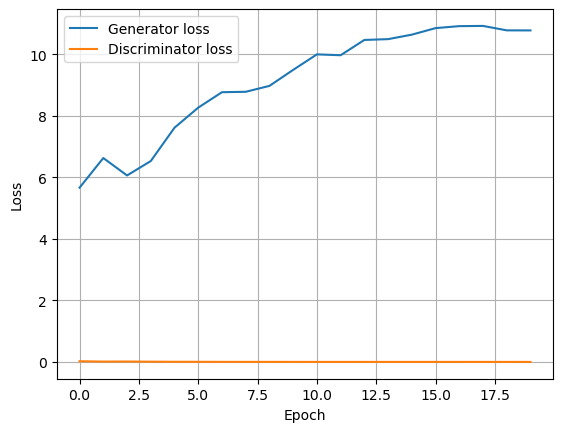

In [102]:
plt.plot(all_g_losses, label='Generator loss')
plt.plot(all_d_losses, label='Discriminator loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

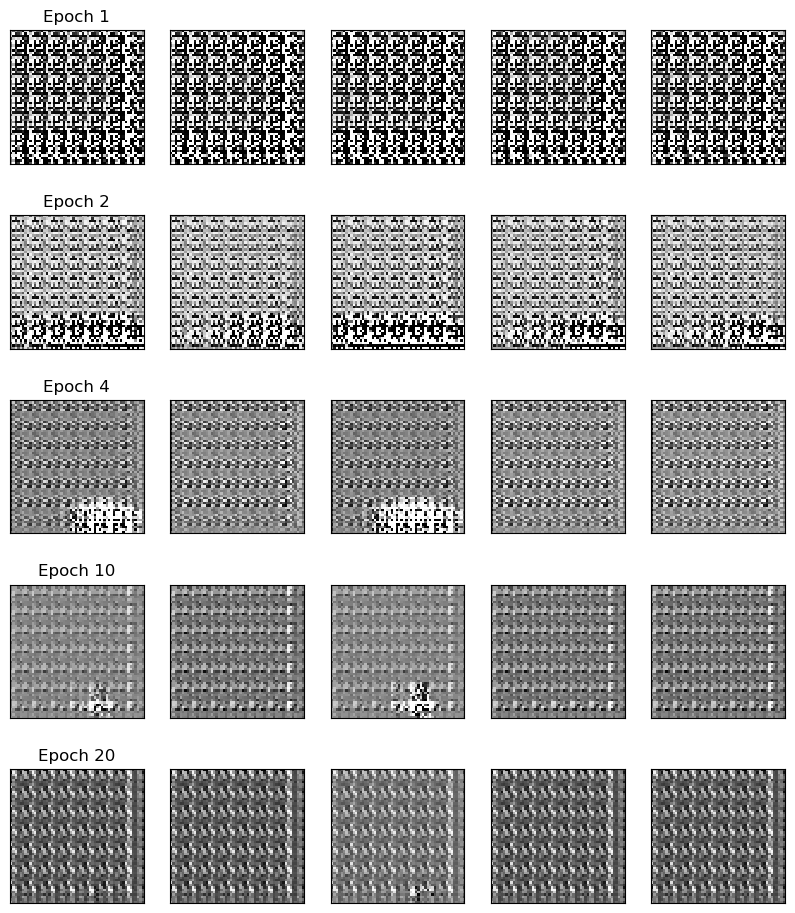

In [115]:

selected_epochs = [1, 2, 4, 10, 20]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        plt.subplot(6, 5, i*5+j+1)
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            plt.title(f'Epoch {e}')
        image = np.clip(epoch_samples[e-1][j], 0, 1)
        # Reshape image to (56, 56)
        image = np.squeeze(image)
        plt.imshow(image, cmap='gray', interpolation='nearest')

plt.show()


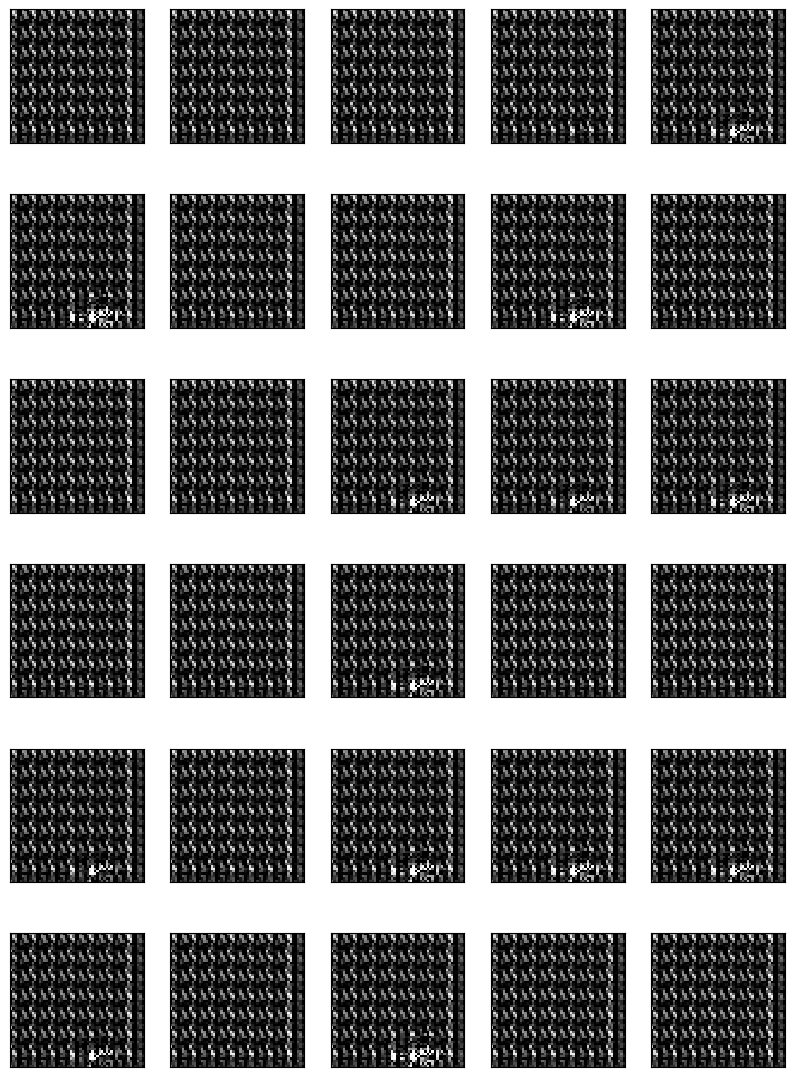

In [116]:
z = torch.randn(batch_size, codings_size, 1, 1)

images = np.clip(g(z).detach().permute(0, 2, 3, 1), 0, 1)
fig = plt.figure(figsize=(10, 14))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i], cmap='gray', interpolation='nearest')

# Classification Models

### Machine Learning Models

#### Random Forest Model

In [158]:
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier()

nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_test.shape
X_test2 = X_test.reshape((nsamples,nx*ny*nrgb))

rf_model.fit(X_train2,y_train)

y_pred = rf_model.predict(X_test2)
y_pred

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

In [165]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy_score(y_pred, y_test)
print(classification_report(y_pred, y_test, zero_division=1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       929
           1       1.00      1.00      1.00       960
           2       0.69      0.96      0.81       693
           3       0.80      1.00      0.89       767

   micro avg       0.86      0.99      0.92      3349
   macro avg       0.86      0.99      0.92      3349
weighted avg       0.88      0.99      0.93      3349
 samples avg       0.86      0.99      0.86      3349

